In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from scipy.stats import mannwhitneyu

In [12]:
# Load the distance matrix
distance_matrix = pd.read_csv("distance-matrix.tsv", sep='\t', index_col=0).values

# Load the cleaned ASV data with metadata (Group, Age, BMI, etc.)
df = pd.read_csv("../../../cleaned_asv_df.csv")

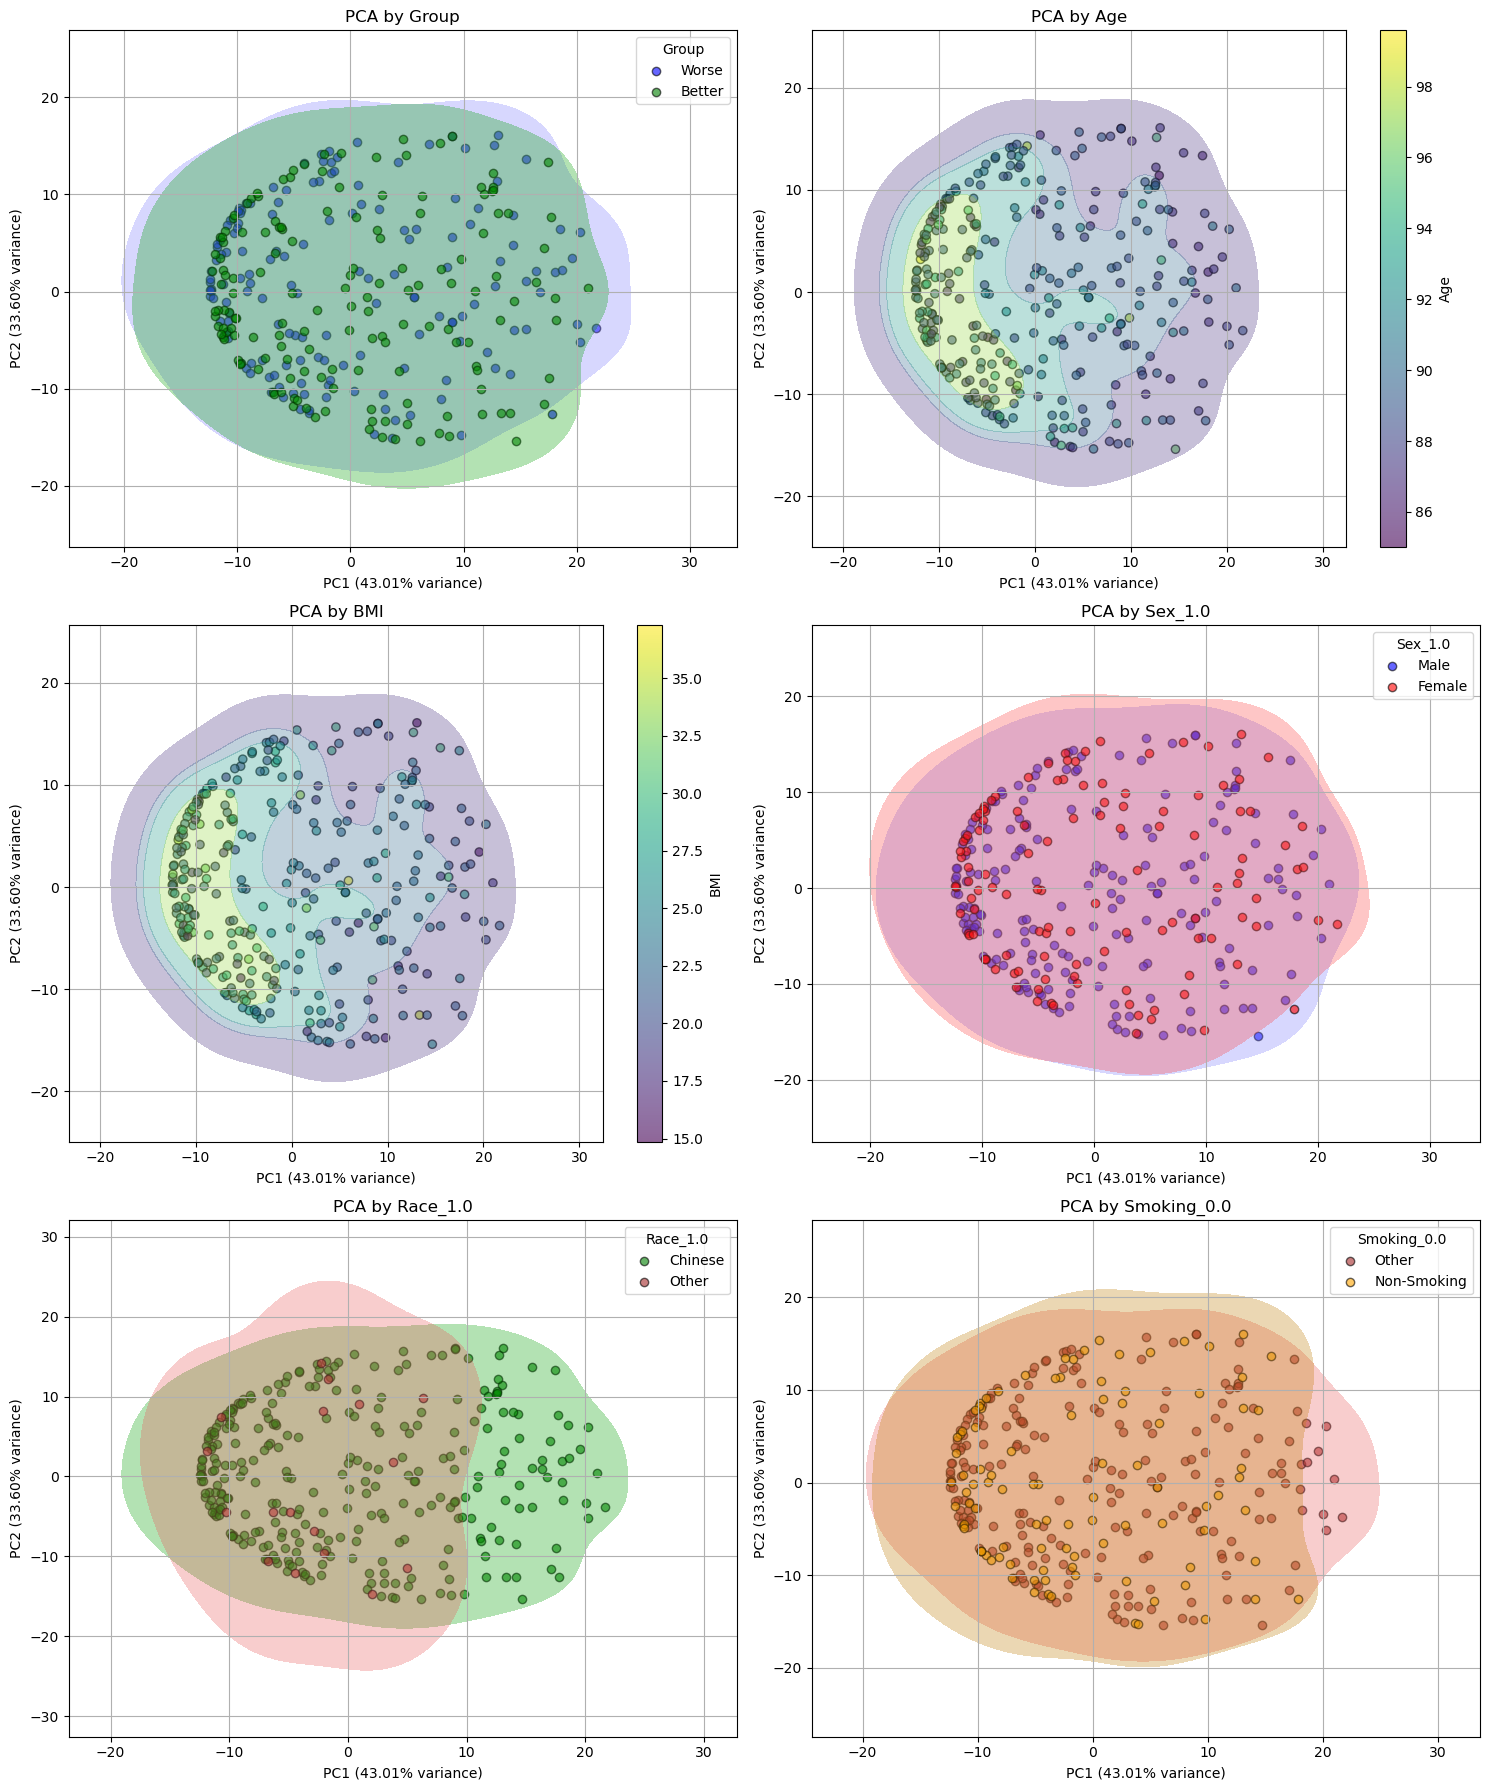

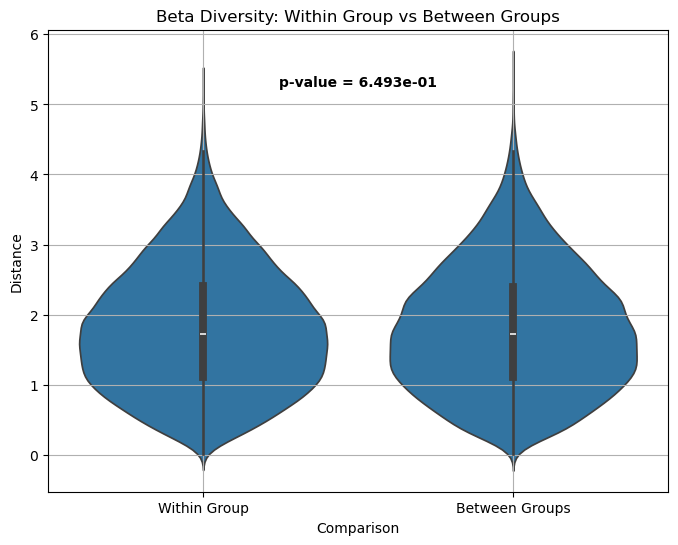

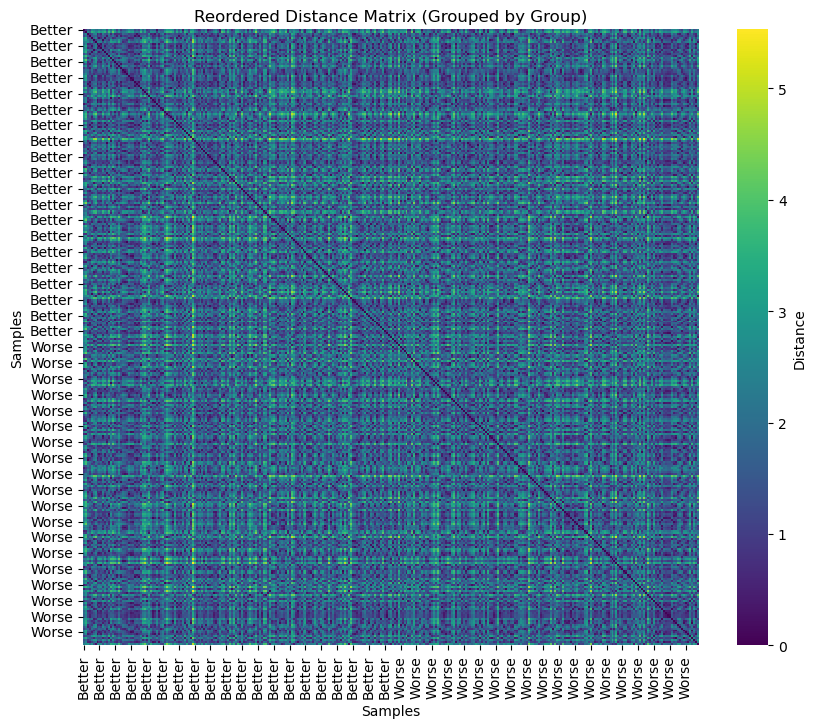

In [6]:

# Perform PCA on the distance matrix
pca = PCA(n_components=2)
pca_sample_scores = pca.fit_transform(distance_matrix)
explained_variance = pca.explained_variance_ratio_

# Dictionary to assign colors for different groups
colors = {
    'Female': 'red',
    'Male': 'blue',
    'Chinese': 'green',
    'Other': 'purple',
    'Non-Smoking': 'orange',
    'Other': 'brown',
    'Better': 'green',
    'Worse': 'blue'
}

variables = ['Group', 'Age', 'BMI', 'Sex_1.0', 'Race_1.0', 'Smoking_0.0']
group_labels = {
    'Sex_1.0': {1.0: 'Female', 0.0: 'Male'},
    'Race_1.0': {1.0: 'Chinese', 0.0: 'Other'},
    'Smoking_0.0': {0.0: 'Non-Smoking', 1.0: 'Other'}
}

# Create subplots for each variable
fig, axes = plt.subplots(3, 2, figsize=(15, 18))
axes = axes.flatten()

# Loop through variables to generate PCA plots with density
for i, var in enumerate(variables):
    ax = axes[i]
    
    # For continuous variables (Age, BMI), use a scatter plot with color gradient
    if var in ['Age', 'BMI']:
        scatter = ax.scatter(
            pca_sample_scores[:, 0],  # PC1
            pca_sample_scores[:, 1],  # PC2
            c=df[var],                # Continuous variable for color
            cmap='viridis',
            alpha=0.6,
            edgecolor='k'
        )
        plt.colorbar(scatter, ax=ax, label=var)
        
        # Add density plot
        sns.kdeplot(
            x=pca_sample_scores[:, 0],
            y=pca_sample_scores[:, 1],
            ax=ax,
            fill=True,
            cmap='viridis',
            alpha=0.3,
            thresh=0.05,
            levels=5
        )

    # For categorical variables, use different colors for each category and add density
    else:
        unique_groups = df[var].unique()
        label_dict = group_labels.get(var, {g: g for g in unique_groups})
        
        for group in unique_groups:
            group_indices = df[var] == group
            
            # Get label (e.g., Female/Male for Sex_1.0)
            label = label_dict.get(group, group)
            scatter_color = colors.get(label, 'blue')
            
            # Plot scatter
            ax.scatter(
                pca_sample_scores[group_indices, 0],  # PC1
                pca_sample_scores[group_indices, 1],  # PC2
                label=label,
                alpha=0.6,
                edgecolor='k',
                color=scatter_color
            )
            
            # Add density plot
            sns.kdeplot(
                x=pca_sample_scores[group_indices, 0],
                y=pca_sample_scores[group_indices, 1],
                ax=ax,
                color=scatter_color,
                alpha=0.3,
                fill=True,
                thresh=0.05,
                levels=2
            )
        
        ax.legend(title=var)

    # Add axis labels and title
    ax.set_xlabel('PC1 (%.2f%% variance)' % (explained_variance[0] * 100))
    ax.set_ylabel('PC2 (%.2f%% variance)' % (explained_variance[1] * 100))
    ax.set_title(f'PCA by {var}')
    ax.grid(True)

# Adjust layout
plt.tight_layout()

# Save the plot
plt.savefig('all_combined_pca_plots.png', dpi=300)
plt.show()

# Violin Plot for Within vs Between Group Beta Diversity

within_group_distances = []
outside_group_distances = []

n_samples = distance_matrix.shape[0]
group_labels = df['Group'].values

for i in range(n_samples):
    for j in range(i + 1, n_samples):
        if group_labels[i] == group_labels[j]:  # Within group
            within_group_distances.append(distance_matrix[i, j])
        else:  # Between groups
            outside_group_distances.append(distance_matrix[i, j])

# Perform Mann-Whitney U test
stat, p_value = mannwhitneyu(within_group_distances, outside_group_distances)

# Prepare data for violin plot
distance_data = pd.DataFrame({
    'Distance': within_group_distances + outside_group_distances,
    'Comparison': ['Within Group'] * len(within_group_distances) + ['Between Groups'] * len(outside_group_distances)
})

# Create the violin plot
plt.figure(figsize=(8, 6))
sns.violinplot(x='Comparison', y='Distance', data=distance_data)
plt.text(0.5, max(distance_data['Distance']) * 0.95, f'p-value = {p_value:.3e}', 
         horizontalalignment='center', size='medium', color='black', weight='semibold')
plt.title('Beta Diversity: Within Group vs Between Groups')
plt.ylabel('Distance')
plt.grid(True)
plt.savefig("beta_diversity_violin.png")
plt.show()

# Heatmap of Reordered Distance Matrix by Group

sorted_indices = np.argsort(group_labels)
reordered_distance_matrix = distance_matrix[sorted_indices, :][:, sorted_indices]
sorted_group_labels = group_labels[sorted_indices]

distance_df = pd.DataFrame(reordered_distance_matrix, index=sorted_group_labels, columns=sorted_group_labels)

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(distance_df, cmap='viridis', square=True, cbar_kws={'label': 'Distance'})
plt.title('Reordered Distance Matrix (Grouped by Group)')
plt.xlabel('Samples')
plt.ylabel('Samples')
plt.savefig("reordered_distance_matrix.png")
plt.show()


In [14]:
import umap

# Step 2: Apply UMAP to the distance matrix
# Initialize UMAP (reduce to 2 dimensions for visualization)
reducer = umap.UMAP(n_components=2, metric='precomputed', random_state=42)

# Since it's a distance matrix, we use the 'precomputed' metric in UMAP
umap_embedding = reducer.fit_transform(distance_matrix)

# Step 3: group labels
#distance_matrix['Group'] = df['Group']  # Add group labels to the matrix

/root/anaconda3/envs/qiime2/lib/python3.8/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


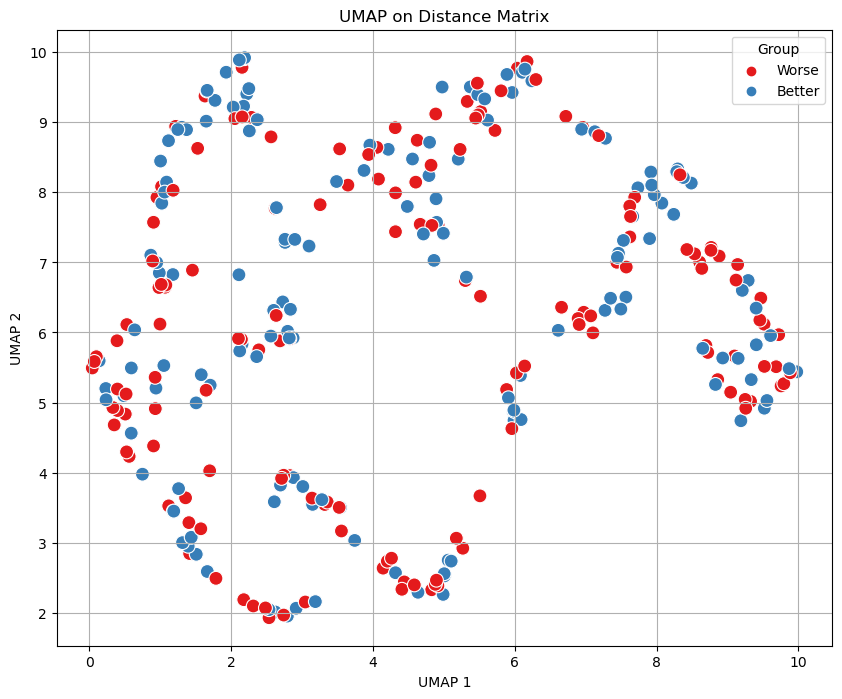

In [15]:
# Step 4: Plot the UMAP embedding
plt.figure(figsize=(10, 8))
sns.scatterplot(x=umap_embedding[:, 0], y=umap_embedding[:, 1], hue=df['Group'], palette='Set1', s=100)
plt.title('UMAP on Distance Matrix')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend(title='Group')
plt.grid(True)
plt.savefig('umap_phylogeny_plot.png', dpi=300)
plt.show()